# Adversarial VAE detection on MNIST

## Method

The adversarial VAE detector is first trained on a batch of unlabeled but normal (*not adversarial*) data. The loss is however different from traditional VAE training and focuses on minimizing the KL-divergence between a classifier's predictions on the original and reconstructed data. When an adversarial instance is fed to the VAE, the KL-divergence between the predictions on the adversarial example and the reconstruction is large. The reconstruction does not contain the adversarial artefacts and has a very different prediction distribution. As a result, the adversarial instance is flagged.

## Dataset

traffic signs

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import zipfile
import logging

from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
import alibi_detect.ad as adv
#from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score

tf.keras.backend.clear_session()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

# Load traffic signs data

In [3]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 32, 32, 3).astype('float32') / 255
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32') / 255
split_train_val = int(0.8 * X_train.shape[0])
print(split_train_val)
X_val, y_val = X_train[split_train_val:], y_train[split_train_val:]
X_train, y_train = X_train[:split_train_val], y_train[:split_train_val]
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


40000
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


### Show example

Sample instance from the signs data set.


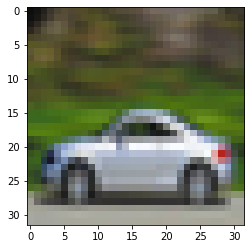

In [4]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

## Create and train traffic signs model

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [model_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/model_mnist/) folder to e.g. the local directory ```my_dir```. Alternatively,  if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/model_mnist my_dir
```

In [5]:
load_signs_model = True

In [6]:
"""
filepath = './model_cifar/'
if load_signs_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
"""

"\nfilepath = './model_cifar/'\nif load_signs_model:\n    model = load_tf_model(filepath)\nelse:\n    # define model\n    inputs = Input(shape=(X_train.shape[1:]))\n    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)\n    x = MaxPooling2D(pool_size=2)(x)\n    x = Dropout(.3)(x)\n    \n    x = Conv2D(32, 2, padding='same', activation='relu')(x)\n    x = MaxPooling2D(pool_size=2)(x)\n    x = Dropout(.3)(x)\n    \n    x = Flatten()(x)\n    x = Dense(256, activation='relu')(x)\n    x = Dropout(.5)(x)\n    logits = Dense(10, name='logits')(x)\n    outputs = Activation('softmax', name='softmax')(logits)\n    model = Model(inputs=inputs, outputs=outputs)\n    model.compile(loss='categorical_crossentropy',\n                  optimizer='adam',\n                  metrics=['accuracy'])\n"

In [7]:
filepath = './model_cifar/'
if load_signs_model:
    model = load_tf_model(filepath)
else:
    # define model   
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
 
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
 
    x = Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)#
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                  metrics=['accuracy'])

In [8]:
augment_data = False

In [9]:
if not augment_data:
    # train model
    model.fit(X_train[:1000],
              y_train[:1000],
              epochs=2,
              batch_size=256,
              verbose=1,
              validation_data=(X_val[:100], y_val[:100])
              )

else:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=32),
                        epochs=15,
                        validation_data=(X_test, y_test),
                        workers=1)
# save model
save_tf_model(model, filepath)

Train on 1000 samples, validate on 100 samples
Epoch 1/2
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.8224 - accuracy: 0.7030 - val_loss: 1.6258 - val_accuracy: 0.4200
Epoch 2/2
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7652 - accuracy: 0.7360 - val_loss: 1.6402 - val_accuracy: 0.4300


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928 

In [11]:
# evaluate model
results = model.evaluate(X_val[:100], y_val[:100], batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 1.5346 -- accuracy: 0.4100


In [6]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

NameError: name 'model' is not defined

In [13]:
probs = model(X_test).numpy()

In [14]:
probs.shape

(10000, 10)

In [15]:
probs.max(axis=1).mean()

0.39384034

## Train Adversarial VAE for MNIST

You can again either manually download the relevant files in the [ad_vae_mnist](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad_vae_mnist/) folder to e.g. the local directory ```my_dir``` or use ```gsutil```:

```bash
!gsutil cp -r gs://seldon-models/alibi-detect/ad_vae_mnist my_dir
```

In [11]:
load_adversarial_detector = False

In [12]:
#encoder_net = tf.keras.Sequential(
#    [
#        InputLayer(input_shape=(32, 32, 3)),
#        Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
#        #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25),
#        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
#        MaxPooling2D(pool_size=(2, 2)),
#        Dropout(0.25)
#    ]
#)

In [13]:
latent_dim = 160

encoder_net = tf.keras.Sequential(
      [
          Conv2D(32, (3,3), padding='same', activation='relu'),
          Conv2D(32, (3,3), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.25),
          Conv2D(64, (3,3), padding='same', activation='relu'),
          Conv2D(64, (3,3), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.25),
          Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
          Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(0.4),
          Flatten(),
          Dense(512, activation='relu'),
          Dropout(0.5)
      ])

# initialize adversarial detector
#ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
#                        model=model,
#                        encoder_net=encoder_net,  # can also pass VAE model instead
#                        decoder_net=decoder_net,  # of separate encoder and decoder
#                        latent_dim=latent_dim,
#                        samples=2,  # nb of samples drawn by VAE
#                        beta=0.  # weight on KL-divergence loss term of latent space
#                       )

## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [14]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [15]:
nb_adv = 500
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_test[ids]
y_adv = y_test[ids]
print(X_to_adv.shape)

(500, 32, 32, 3)


In [16]:
X_adv = projected_gradient_descent(model_logits, None, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

In [17]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)

X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
X_adv = X_adv[(y_pred != y_pred_adv)]

In [18]:

y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
X_val = np.concatenate([X_to_adv, X_adv], axis=0)
print(X_val.shape, y_val.shape)

(648, 32, 32, 3) (648,)


In [19]:
def advesarial_accuracy(ground_truth_val, preds_val):
    score_val = preds_val['data']['instance_score']
    preds_val = preds_val['data']['is_adversarial']

    acc = accuracy_score(ground_truth_val, preds_val)

    return acc

In [20]:
X_val.shape

(648, 32, 32, 3)

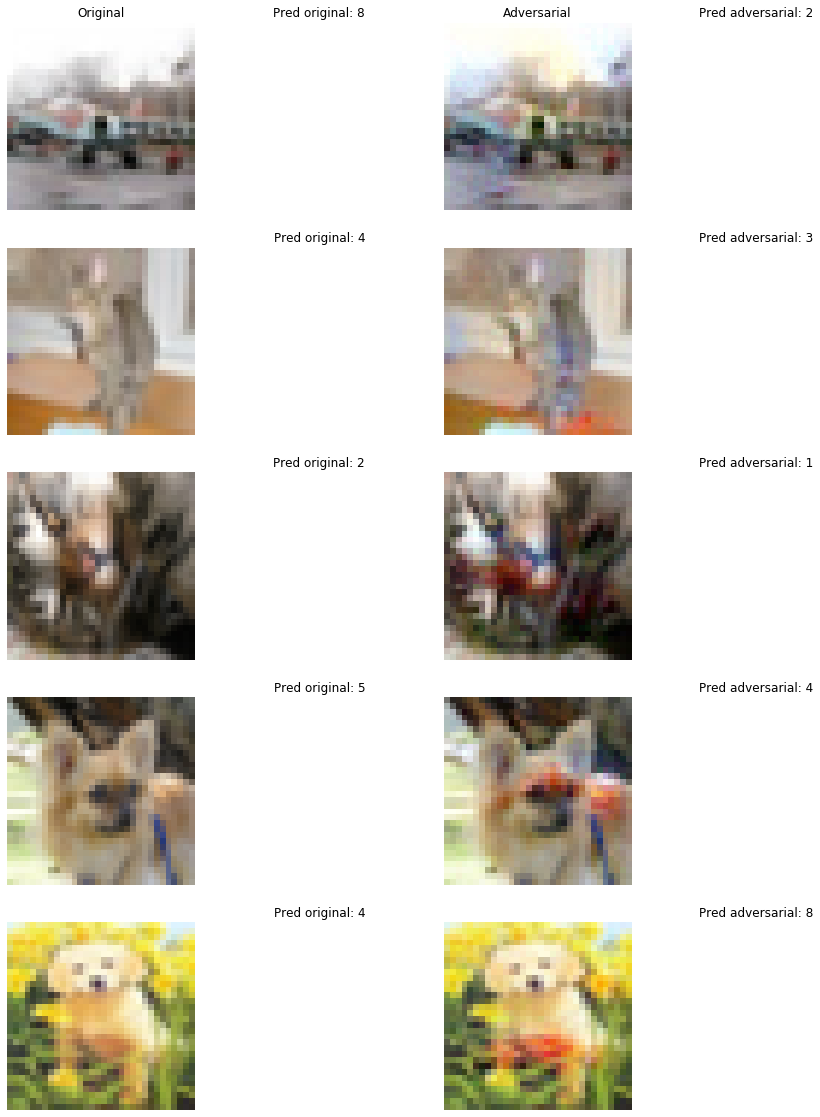

In [21]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (32, 32, 3)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

In [22]:
from importlib import reload

In [23]:
reload(adv)

<module 'alibi_detect.ad' from '/home/fdz/git/fork-alibi-detect/alibi_detect/ad/__init__.py'>

# Run cell

---

In [25]:
encoder_params = {}
decoder_params = {}
vae_params = {}

log_dir='/home/fdz/experiments/cifar/model_0/vae_0/'
filepath = './ad_vae_signs/'

if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = 20
    """
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(32, (3,3), padding='same', activation='relu'),
          #Conv2D(32, (3,3), padding='same', activation='relu'),
          #MaxPooling2D(pool_size=(2,2)),
          
          #Conv2D(32, (3,3), strides=2, padding='same', activation='relu'),
          Conv2D(64, (3,3), padding='same', activation='relu'),
          #MaxPooling2D(pool_size=(2,2)),

          Flatten(),
          Dense(512, activation='relu')
      ]) 
    """
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(32, (3,3), padding='same', activation='relu'),
          Conv2D(32, (3,3), strides=2, padding='same', activation='relu'),
          #MaxPooling2D(pool_size=(2,2)),
          #Dropout(0.25),
          Conv2D(64, (3,3), padding='same', activation='relu'),
          Conv2D(64, (3,3), strides=2, padding='same', activation='relu'),
          #MaxPooling2D(pool_size=(2,2)),
          #Dropout(0.25),
          Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
          Conv2D(128, (3,3), strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4)),
          #MaxPooling2D(pool_size=(2,2)),
          #Dropout(0.4),
          Flatten(),
          Dense(512, activation='relu'),
          #Dropout(0.5)
      ])

    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128, activation='relu'),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, (3, 3), strides=1, padding='same', activation='sigmoid')
      ])
    
    # initialize adversarial detector
    ad = adv.AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=5,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )

    runs = next(os.walk(log_dir))[1]
    run_id = 0
    while str(run_id) in runs:
        run_id += 1
        if run_id > 100:
            break
    run_dir = log_dir + str(run_id)
    print('Creating log dir:', run_dir)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
        
    if not load_adversarial_detector:
        # train
        ad.fit(X_train[:100],
           validation_data=(X_test[:100], None),
           adversarial_data=(X_val, y_val),
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=Adam(),
           epochs=10,
           verbose=True,
          log_metric_val='acc',
          log_dir=run_dir)
    
        # save the trained outlier detector
        save_detector(ad, filepath)

Creating log dir: /home/fdz/experiments/cifar/model_0/vae_0/16
3/2 [=] - 13s 4s/step - loss: 2.3699 - loss_valid: 1.9105 - detection_acc: 0.5000


/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3/2 [=] - 13s 4s/step - loss: 2.3274 - loss_valid: 1.8046 - detection_acc: 0.5000


/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3/2 [=] - 13s 4s/step - loss: 1.8392 - loss_valid: 1.4139 - detection_acc: 0.5000


/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3/2 [=] - 13s 4s/step - loss: 1.8017 - loss_valid: 1.3987 - detection_acc: 0.5000


/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3/2 [=] - 13s 4s/step - loss: 1.7339 - loss_valid: 1.4045 - detection_acc: 0.5108


 ----

In [25]:
encoder_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [26]:
decoder_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2048)              43008     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 32)       

In [35]:
df_adv_scores = pd.read_csv('/home/fdz/experiments/cifar/model_0/vae_0/12/adv_scores.csv')
df_losses = pd.read_csv('/home/fdz/experiments/cifar/model_0/vae_0/12/losses.csv')
df_scores = pd.read_csv('/home/fdz/experiments/cifar/model_0/vae_0/12/scores.csv')

In [36]:
df_adv_scores.shape

(100, 3)

In [37]:
X_val.shape

(686, 32, 32, 3)

In [38]:
df_losses

,train,test
0,2.720927,1.999785
1,2.503652,1.964180


In [39]:
df_scores

,acc,f1,rec,prec
0,0.96,0.0,0.0,0.0
1,1.00,0.0,0.0,0.0


## Detect adversarial instances

In [48]:
ad.infer_threshold(X_train[:2000], threshold_perc=90.)

In [49]:
ad.threshold

0.15354246795177465

In [50]:
ad.samples

5

In [51]:
ad_preds = ad.predict(X_val, return_instance_score=True)

In [81]:
y_pred = ad_preds['data']['is_adversarial']

In [83]:
accuracy_score(y_val, y_pred)

0.5

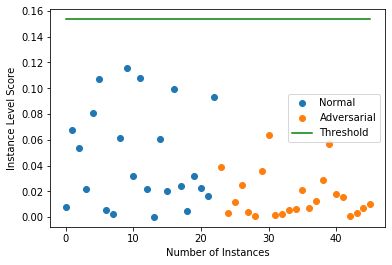

In [53]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X_val.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

IndexError: index 50 is out of bounds for axis 0 with size 46

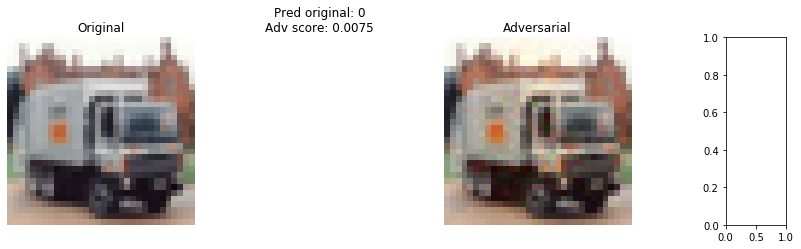

In [57]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    ax_3.title.set_text('Pred Adversarial: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Adversarial detection performances

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [58]:
kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [59]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(23,) (23,)
0.046047553 0.037674338
0.016580192 0.017260265


In [60]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [61]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))

Adversarial detection accuracy: 0.5


In [62]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.0


/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
print('Confusion matrix')
confusion_matrix(y_true_ad, preds_ad)

Confusion matrix


array([[23,  0],
       [23,  0]])

In [64]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:100]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [65]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.5


In [66]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.0


In [67]:
print('Confusion matrix')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Confusion matrix


array([[23,  0],
       [23,  0]])

In [68]:
idx_sparse = np.random.permutation(len(preds_ad_adv))[:10]
preds_ad_sparse = np.concatenate((preds_ad_test, preds_ad_adv[idx_sparse]))
y_true_ad_sparse = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv[idx_sparse]))))

In [69]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection accuracy: 0.696969696969697


In [70]:
print('Adversarial detection f1:', f1_score(y_true_ad_sparse, preds_ad_sparse))

Adversarial detection f1: 0.0


In [71]:
print('Confusion matrix')
confusion_matrix(y_true_ad_sparse, preds_ad_sparse)

Confusion matrix


array([[23,  0],
       [10,  0]])

## Curves

In [72]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [73]:
perm = np.random.permutation(range(len(kl_adv)))[:500]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [74]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

In [75]:
sigma_plus

0.025359395974416214

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

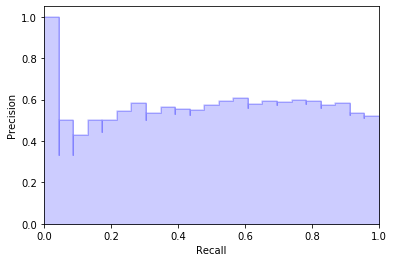

In [76]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

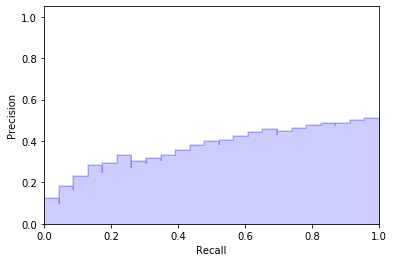

In [77]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Accuracy - f1 scores

In [78]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


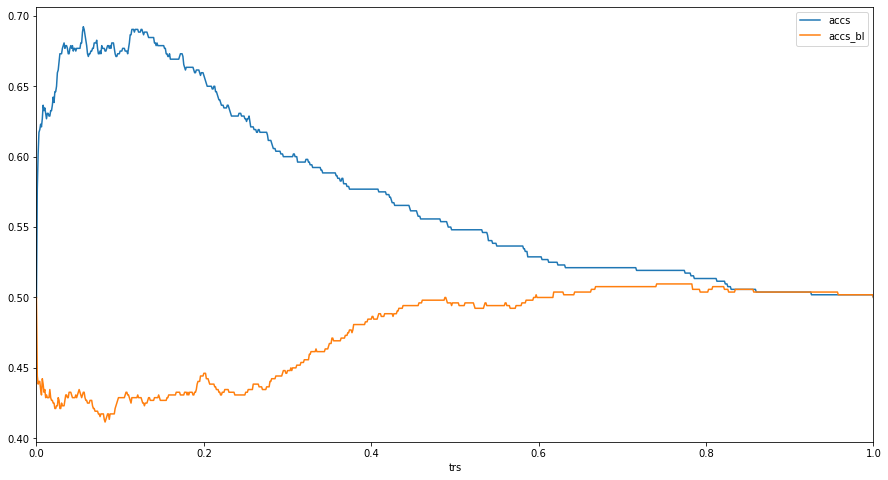

In [287]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


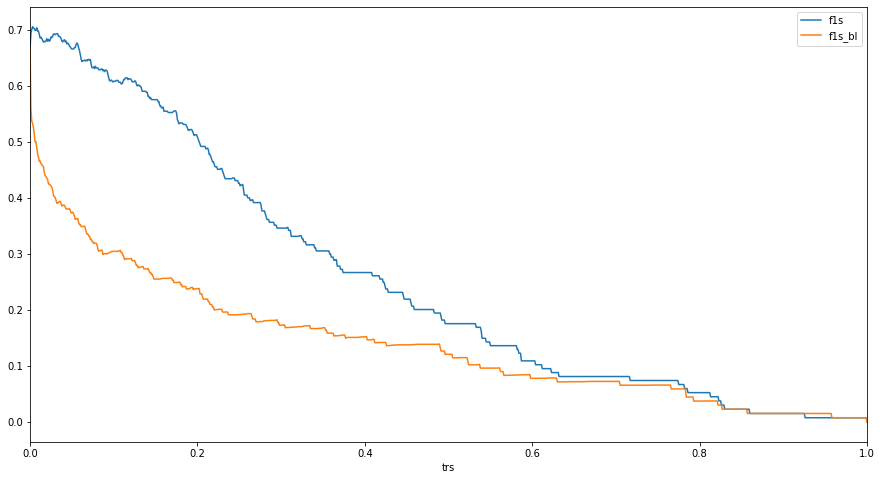

In [288]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [289]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.942260,0.186095,0.570451,0.251748,0.558053,0.103858,0.476948,0.140950
std,0.289108,0.107657,0.210242,0.062488,0.221232,0.226760,0.112698,0.032370,0.112541
min,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.411538,0.000000
25%,0.250000,0.925000,0.038462,0.519231,0.074074,0.382353,0.034615,0.438462,0.065693
50%,0.500000,1.000000,0.096154,0.548077,0.175439,0.461538,0.069231,0.494231,0.120805
75%,0.750000,1.000000,0.276923,0.621154,0.426036,0.642857,0.134615,0.503846,0.191781
max,1.000000,1.000000,1.000000,0.692308,0.705185,1.000000,1.000000,0.509615,0.666667


### Distributions

Vae detector


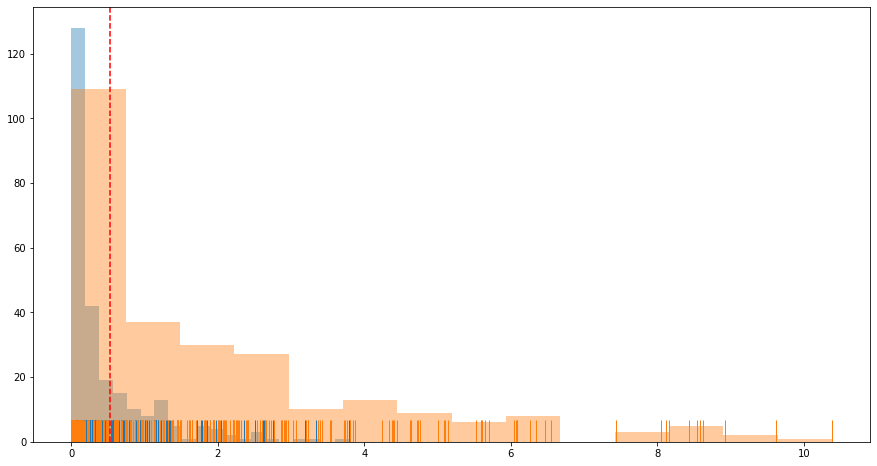

In [290]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


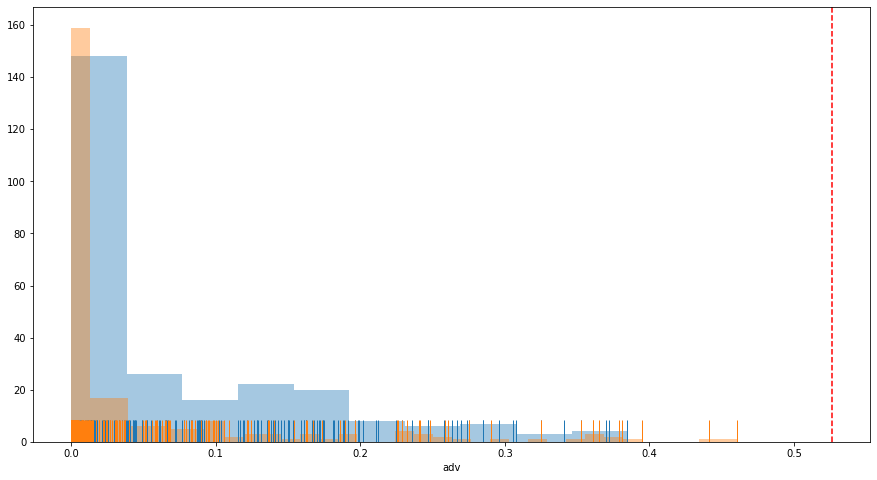

In [291]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)

In [ ]:
from tensorflow.keras.metrics import MeanMe

In [337]:
ad.predict(X_val[:10])

{'data': {'feature_score': None,
  'instance_score': array([1.3335790e-02, 1.4519510e-03, 2.3145833e+00, 4.6050154e-02,
         3.9955443e-01, 1.0918931e-01, 6.4510000e-01, 2.0981470e-01,
         2.2900740e-04, 4.9750900e-01], dtype=float32),
  'is_adversarial': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])},
 'meta': {'name': 'AdversarialVAE',
  'detector_type': 'offline',
  'data_type': None}}